In [1]:
%load_ext autoreload
%autoreload 2
from matplotlib import style; style.use('seaborn-poster')
import sys, numpy as np, matplotlib.pyplot as plt, pickle, os, networkx as nx
sys.path.insert(0, '../')

from Utils.plotting import addGraphPretty, get_shells
fn = '../data/_tipping_points2020-10-04T14:30:35.291467' # tipping point recursion 1
# fn = '../slurm/data/_Potts_recursion1' # center focus 

# fn = "../slurm/data/_Potts_recursion12020-10-06T09:50:11.929260"
# fn = "../slurm/data/_Potts_recursion_center_focus2020-10-06T09:46:45.841583"
from pyprind import prog_bar
def loader(fn):
    output = {}
    for base, folder, files in os.walk(fn):
        for f in files:
            # get pickle split and bin
            if f.endswith('pickle'):
                setting_number = f.split('-')[-2]
                with open(os.path.join(base, f), 'rb') as FILE:
                    data = pickle.load(FILE)
                    output[setting_number] = output.get(setting_number, []) + [data]
    return output
datasets = loader(fn)
 
for k, v in datasets.items():
    print(len(v))

14
14
13


In [2]:
mis = {}
for k, v in datasets.items():
    mi = {}
    for vi in v:
        for kk, vv in vi.get('results').get('mi').items():
            mi[kk] = mi.get(kk, []) + [vv]
    mis[k] = mi

In [3]:
m = next(iter(datasets.values()))[0]
m = m.get("settings").get("model")

<ipython-input-4-3827cd9f33bb>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


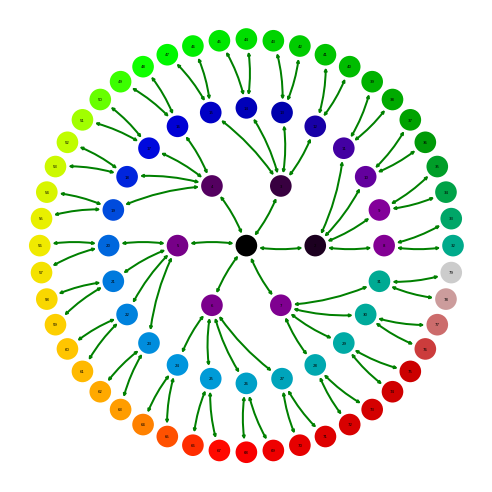

In [4]:
# plt network
from matplotlib import style
from Utils.plotting import get_linear_cmap as glc, get_shells
style.use('seaborn-poster')
shells = get_shells(m.graph)
pos = nx.shell_layout(m.graph,
                      nlist = list(shells.values()),\
                      rotate = 0,\
                      scale = 1,
                 )

colors = glc(m.nNodes)
fig, ax = plt.subplots()
addGraphPretty(m.graph, ax, positions = pos, 
               annotate = dict(fontsize = 100),
              cmap = colors)
ax.axis('off')
fig.show()

NameError: name 'titles' is not defined

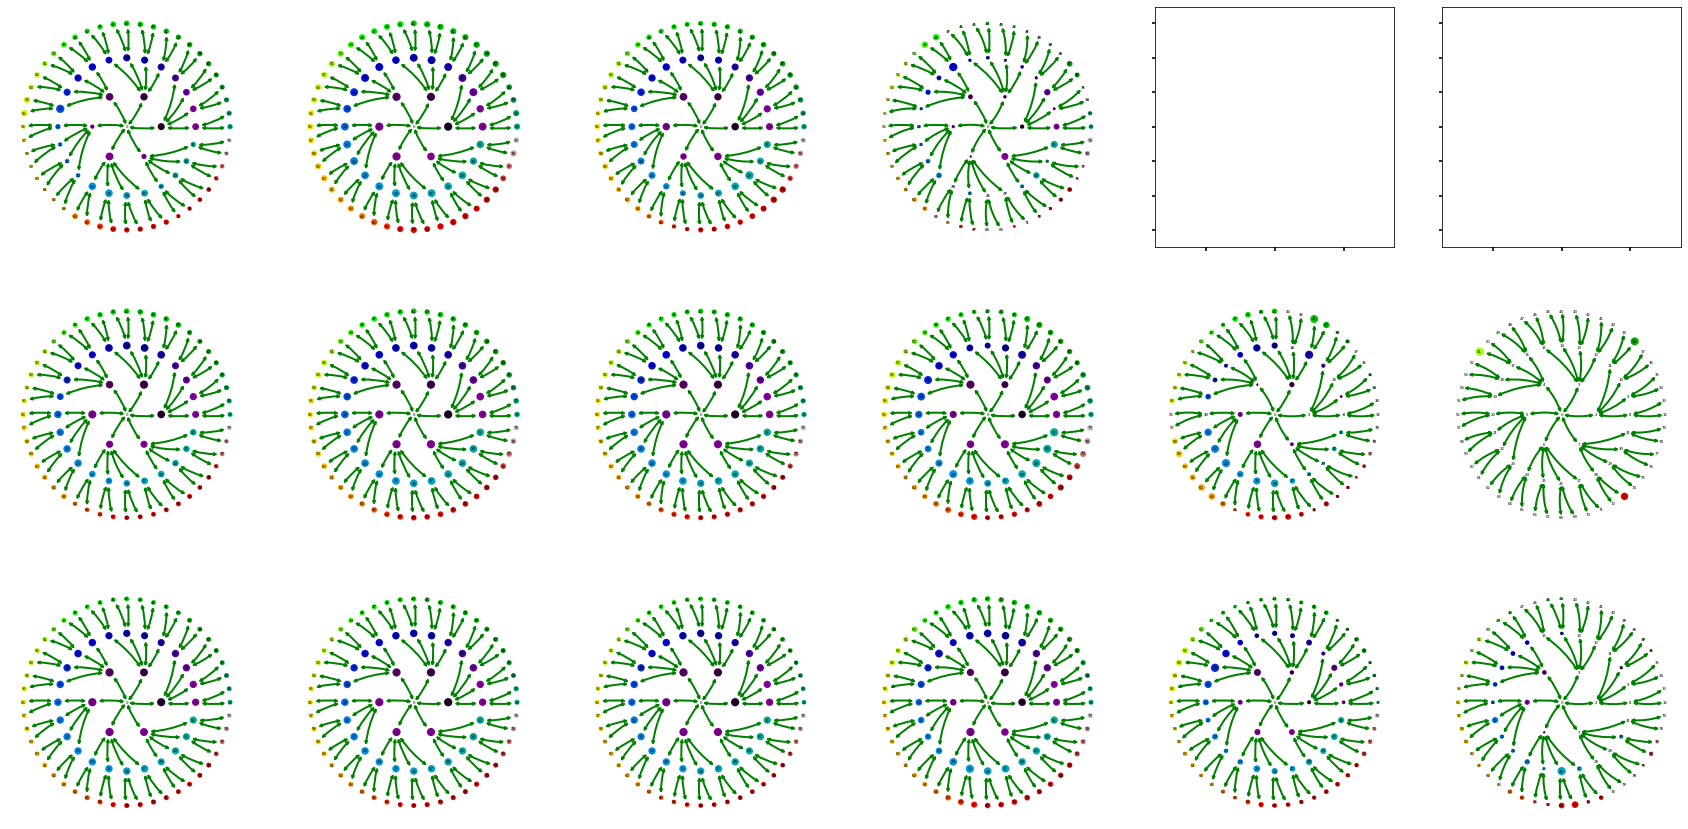

In [8]:
number_of_settings = len(mis)
number_of_tipps    = max((len(i) for i in mis.values()))
fig, ax = plt.subplots(number_of_settings, number_of_tipps, 
                      figsize = (30, 15),
                      sharex = 'all', sharey = 'all')   
# different settings
for axi, (k, v) in zip(ax, mis.items()):
    # all the distances
    for axj, (kk, vv) in zip(axi, v.items()):
        patches = addGraphPretty(m.graph, axj, positions = pos, 
                               annotate = dict(fontsize = 100),
                               cmap = colors).patches
        radius = np.asarray(vv).mean(0).sum(0)
        radius = (radius - radius.min()) / (radius.max() - radius.min())
        radius[np.isnan(radius) == True] = 1
        for patch in patches:
            if label := patch.get_label():
                    idx = m.adj.mapping[label]
                    patch.set(radius = radius[idx] * .03)
        axj.axis('off')

for idx, title in enumerate(titles):
    tax = fig.add_subplot(1, number_of_tipps, idx + 1, 
                          frameon = 0, xticks = [], yticks = [])
    tax.set_title(title, fontsize = 50) 
for axi in ax.flat:
    if not axi.patches:
        axi.axis('off')
fig.subplots_adjust(wspace = 0, hspace = 0)
fig.tight_layout()
fig.show()

In [ ]:
# estimate decay functions
from scipy import optimize
from scipy import integrate
def f(x, a, b, c, d, e, f, g):
    return a + b * np.exp(- c * (x - d))  + e * np.exp(-f *(x - g)) 

# noise parameters
mis_coeffs = {}
integrals =  {}

padding = np.zeros((100, m.nNodes))
start   = int(1e5)
end     = int(2e5)
for k, v in mis.items():
    # distances to tipping
    mis_coeffs[k] = {}
    integrals[k]  = {}
    for kk, vv in prog_bar(v.items()):
        # just average over trials
        vv = np.array(vv).mean(0)
        xr = np.arange(len(vv))
        
        n  = len(vv)
        # append padding
        vv = np.concatenate((vv, padding), axis = 0)
        s = np.linspace(start, end, len(padding))
        xr = np.concatenate((np.arange(n), s), axis = 0)
                            
        coeffs = np.zeros((m.nNodes, len(f.__code__.co_varnames) - 1))
        ints    = np.zeros((m.nNodes, 2))
        for idx in range(m.nNodes):
            coeff, _ = optimize.curve_fit(f, xdata = xr, 
                                          ydata = vv[..., idx],
                                         bounds = (0, np.inf),
                                         maxfev = int(1e5))
             
            coeffs[idx] = coeff
            o   = integrate.quad(lambda x: f(x, *coeff), 0, xr.max() * 10, \
                                 full_output = 1)
            a, b = o[0], o[1]
            ints[idx]   = a, b
        integrals[k][kk] = integrals[k].get(kk, ints)
        mis_coeffs[k][kk] = mis_coeffs[k].get(kk, coeffs)

In [ ]:
%autoreload 2
# visualize time plots
from Utils.plotting import get_linear_cmap as glc


fig, ax = plt.subplots(number_of_settings, number_of_tipps,
                       sharey = 'row',
                       sharex = 'all',
                      figsize = (40, 15))
titles = {} # set is not ordered

from scipy.stats import sem
for axi, (k, v) in zip(ax, mis.items()):
    for axj, (kk, vv) in zip(axi, v.items()):
        vv = np.asarray(vv)
        mean = vv.mean(0)
        std  = sem(vv, 0)
        xr   = np.arange(len(mean))
        xrr  = np.linspace(0, xr.max() * 2)
        for node in range(m.nNodes):
            axj.plot(xr, mean[..., node], 
                        color = colors[node])
            axj.fill_between(xr, mean[..., node] + std[..., node], 
                             mean[..., node] - std[..., node],
                            alpha = .1, color = colors[node])
            axj.plot(xrr, f(xrr, *mis_coeffs[k][kk][node]),
                    color = colors[node], linestyle = '--')
        if isinstance(kk, float):
            kk = np.round(kk, 2)
        titles[kk] =  titles.get(kk, 1)

for idx, title in enumerate(titles):
    tax = fig.add_subplot(1, number_of_tipps, idx + 1, 
                          frameon = 0, xticks = [], yticks = [])
    tax.set_title(title, fontsize = 50)
tax = fig.add_subplot(111, frameon = 0, xticks = [], yticks = [])

tax.set_xlabel("t", 
               labelpad = 45, 
               fontsize = 60)
tax.set_ylabel("$I(S^{t_0} : s_i^{t_0 + t})$", 
               labelpad = 45, 
               fontsize = 60)
fig.subplots_adjust(wspace = 0, hspace = .05)
fig.tight_layout()
fig.show()

In [ ]:
# plotting baselines
fig, ax = plt.subplots(number_of_settings, 
                       number_of_tipps,
                      sharex = 'all', 
                       sharey = 'all',
                      figsize = (30, 10))
spacing = 5

labels = "0.9 0,8 0.7".split()
for axi, (k, v) in zip(ax, mis_coeffs.items()):
    for axj, (kk, vv) in zip(axi, v.items()):
        if addC:
            axj.set_title(kk)
        axj.plot(vv[:, 0])
        axj.set_xticks(np.arange(m.nNodes)[::spacing],
              )
        axj.set_xticklabels(list(m.adj.rmapping.keys())[::spacing], 
                    fontdict = dict(fontsize = 13), 
                    )
tax = fig.add_subplot(111, 
                     frameon = 0,
                     xticks = [],
                     yticks = [])
tax.set_ylabel("baseline", labelpad = 85)
tax.set_xlabel("node", labelpad = 55)

for idx, k in enumerate(v):
    tax = fig.add_subplot(1, number_of_tipps, idx + 1, frameon = [], 
                          xticks = [], yticks = [],
                   )
    tax.set_title(k)

for idx, k in enumerate(mis_coeffs):
    tax = fig.add_subplot(number_of_settings, 1, idx + 1, frameon = 0,
                   xticks = [], yticks = [])
    tax.set_ylabel(labels[int(k)], labelpad = 60)
fig.subplots_adjust(wspace = 0, hspace = 0)
fig.show()

In [ ]:
from sklearn.preprocessing import quantile_transform as scaler
fig, ax = plt.subplots(number_of_settings, number_of_tipps, 
                      figsize = (30, 15),
                      sharex = 'all', sharey = 'all')   

percentiles = np.linspace(1, 100, 20, dtype = int)
# different settings
for axi, (k, v) in zip(ax, integrals.items()):
    # all the distances
    for axj, (kk, vv) in zip(axi, v.items()):
        patches = addGraphPretty(m.graph, axj, positions = pos, 
                               annotate = dict(fontsize = 100),
                               cmap = colors).patches
        radius = np.asarray(vv)[:,0]
        tmp_ = np.percentile(radius, percentiles)
        radius = np.digitize(radius, tmp_)
        radius = (radius - radius.min()) / (radius.max() - radius.min())
        radius[np.isnan(radius) == True] = 1
        for patch in patches:
            if label := patch.get_label():
                    idx = m.adj.mapping[label]
                    patch.set(radius = radius[idx] * .03)
        axj.axis('off')

for idx, title in enumerate(titles):
    tax = fig.add_subplot(1, number_of_tipps, idx + 1, 
                          frameon = 0, xticks = [], yticks = [])
    tax.set_title(title, fontsize = 50) 
for axi in ax.flat:
    if not axi.patches:
        axi.axis('off')
        
# didnt put this in this dataset
labels = "0.9 0.8 0.7".split()
for idx, (k, v) in enumerate(datasets.items()):
    tax = fig.add_subplot(number_of_settings, 1, idx +1,\
                   frameon = 0,
                   xticks = [],
                   yticks = [])
    tax.set_ylabel(labels[idx])
    
fig.subplots_adjust(wspace = 0, hspace = 0)
fig.tight_layout()
fig.show()

_IMI as a function of distance (columns) to the tipping point (rows). Three observations can be made. Firstly, distance decreases, nodes obtain higher entropy. The outer nodes are in a stable state, after which they flip. This information traverses to the inner rings gradually. Secondly, the center node seems to be stabilized. Third, the two prior effects are consistent across noise._

# Implications of simulations
Hub node seems to be frozen as a function to tipping point. Why?
- The windowing is currently done prior to the tipping point, i.e. the states are binned _before_ the tipping occurs, perhaps the center nodes flips after the majority of the system has flipped.
  - (A) Redo experiments but only look at the hub node flipping as a marker
  - (B) What happens when the rings are inner-connected?
  - (C) What happens when the difference in degree between rings is higher (jump parameter)
- The results above bare resemblance to filtering of noise in neurons. Perhaps we can use IT to look at the information flow as a function of noise.

In [ ]:
%autoreload 2
from Utils.graph import recursive_tree
from Utils.plotting import get_shell_layout
fig, ax = plt.subplots()
g = recursive_tree(7, 3)

pos = get_shell_layout(g, rotate = -.01)
nx.draw(g, ax = ax, pos = pos)